# NYC Landmarks Vector Database - Query Testing

This notebook provides testing and examples for the vector query capabilities of the NYC Landmarks Vector Database. It demonstrates how to connect to the Pinecone database, execute various types of queries, and analyze the results.

## Objectives

1. Test basic vector search functionality
2. Demonstrate filtering capabilities
3. Analyze query performance and result relevance
4. Visualize search results

This notebook represents Phase 1 of the Query API Enhancement, focusing on establishing the foundations for more advanced query capabilities.

## 1. Setup & Imports

First, we'll import the necessary libraries and set up the environment.

In [61]:
# Standard libraries
import sys
import time

# Visualization libraries
import matplotlib.pyplot as plt

# Data analysis libraries
import numpy as np
import seaborn as sns

# Add project directory to path
sys.path.append("..")

# Set visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Configure logging
import logging

# Import project modules
from nyc_landmarks.config.settings import settings
from nyc_landmarks.embeddings.generator import EmbeddingGenerator
from nyc_landmarks.vectordb.pinecone_db import PineconeDB

logger = logging.getLogger()
logging.basicConfig(
    level=settings.LOG_LEVEL.value,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

## 2. Pinecone Connection

Next, we'll establish a connection to the Pinecone vector database and verify the connection.

In [52]:
# Initialize the Pinecone database client
pinecone_db = PineconeDB()

# Check if the connection was successful
if pinecone_db.index:
    print(f"✅ Successfully connected to Pinecone index: {pinecone_db.index_name}")
    print(f"Namespace: {pinecone_db.namespace}")
    print(f"Dimensions: {pinecone_db.dimensions}")
else:
    print(
        "❌ Failed to connect to Pinecone. Check your credentials and network connection."
    )

2025-05-23 17:27:54,591 - nyc_landmarks.vectordb.pinecone_db - INFO - Initialized Pinecone client


INFO:nyc_landmarks.vectordb.pinecone_db:Initialized Pinecone client


2025-05-23 17:27:54,598 - nyc_landmarks.vectordb.pinecone_db - INFO - Connected to Pinecone index: nyc-landmarks


INFO:nyc_landmarks.vectordb.pinecone_db:Connected to Pinecone index: nyc-landmarks


✅ Successfully connected to Pinecone index: nyc-landmarks
Namespace: landmarks
Dimensions: 1536


In [53]:
# Get index statistics
stats = pinecone_db.get_index_stats()

# Check for errors
if "error" in stats:
    print(f"❌ Error retrieving index stats: {stats['error']}")
    # Create fallback mock stats for demonstration
    total_vector_count = 0
    namespaces = {}
else:
    print("✅ Successfully retrieved index stats")
    total_vector_count = stats.get("total_vector_count", 0)
    namespaces = stats.get("namespaces", {})

print("\n📊 Index Statistics:")
print(f"Total Vector Count: {total_vector_count:,}")
print(f"Dimension: {stats.get('dimension')}")
print(f"Index Fullness: {stats.get('index_fullness')}")

✅ Successfully retrieved index stats

📊 Index Statistics:
Total Vector Count: 35,263
Dimension: 1536
Index Fullness: 0.0


## 3. Basic Vector Search Test

Now let's test the basic vector search capabilities using sample queries about NYC landmarks.

In [54]:
# Initialize the embedding generator
embedding_generator = EmbeddingGenerator()

# Define some sample queries about NYC landmarks
sample_queries = [
    "What is the Empire State Building?",
    "Tell me about the Brooklyn Bridge",
    "What are the historic districts in Manhattan?",
    "What is the architectural style of Grand Central Terminal?",
    "When was the Statue of Liberty designated as a landmark?",
]

print(f"Generated {len(sample_queries)} sample queries for testing.")

INFO:nyc_landmarks.embeddings.generator:Initialized OpenAI client with model: text-embedding-3-small


Generated 5 sample queries for testing.


## Understanding Vector Search Implementation

## PineconeDB Query Implementation

Below is the implementation of `query_vectors` method from the `PineconeDB` class that we'll be using:

In [ ]:
# Source: nyc_landmarks/vectordb/pinecone_db.py

'''
def query_vectors(
    self,
    query_vector: List[float],
    top_k: int = 5,
    filter_dict: Optional[Dict[str, Any]] = None,
) -> List[Dict[str, Any]]:
    """
    Query vectors from Pinecone index.

    Args:
        query_vector: Embedding of the query text
        top_k: Number of results to return
        filter_dict: Dictionary of metadata filters

    Returns:
        List of matching vectors with metadata
    """
    try:
        response = self.index.query(
            vector=query_vector,
            top_k=top_k,
            include_metadata=True,
            filter=filter_dict,
        )

        # Process the response to extract matches
        result_list: List[Dict[str, Any]] = []

        # Handle response.matches which can be a list or other iterable
        # Cast response to Any to handle different return types from Pinecone SDK
        from typing import Any as TypeAny
        from typing import cast

        response_dict = cast(TypeAny, response)

        # Access matches safely
        matches = getattr(response_dict, "matches", [])
        for match in matches:
            # Handle match objects
            match_dict: Dict[str, Any] = {}

            # Extract ID if available
            if hasattr(match, "id"):
                match_dict["id"] = match.id

            # Extract score if available
            if hasattr(match, "score"):
                match_dict["score"] = match.score

            # Extract metadata if available
            if hasattr(match, "metadata"):
                match_dict["metadata"] = match.metadata

            result_list.append(match_dict)

        return result_list

    except Exception as e:
        logger.error(f"Failed to query vectors: {e}")
        return []
'''

# Note: This code block is for reference only and won't be executed

## Our Notebook's Query Function

In this notebook, our `execute_query` function wraps around the `PineconeDB.query_vectors` method to provide additional functionality:

1. **Timing and Performance Metrics**: We measure embedding generation time, query execution time, and total time
2. **Automatic Embedding Generation**: Our function handles text-to-vector embedding using `EmbeddingGenerator`
3. **Structured Results**: The response is packaged with both the results and performance metrics

Our implementation is shown below:

In [67]:
# Function to execute a query and measure performance


def execute_query(query_text, top_k=5, filter_dict=None):
    """Execute a vector search query and return the results along with performance metrics."""
    # Start timing
    start_time = time.time()

    # Generate embedding for the query
    embedding_start = time.time()
    query_embedding = embedding_generator.generate_embedding(query_text)
    embedding_time = time.time() - embedding_start

    # Execute the query
    query_start = time.time()
    results = pinecone_db.query_vectors(
        query_vector=query_embedding, top_k=top_k, filter_dict=filter_dict
    )
    query_time = time.time() - query_start

    # Calculate total time
    total_time = time.time() - start_time

    return {
        "query": query_text,
        "embedding": query_embedding,
        "results": results,
        "metrics": {
            "embedding_time": embedding_time,
            "query_time": query_time,
            "total_time": total_time,
            "result_count": len(results),
        },
    }

In [68]:
def display_query_results(query_result, max_results=None, show_metadata=True):
    """Display query results in a readable format.

    Args:
        query_result: The result dictionary returned by execute_query
        max_results: Maximum number of results to display (default: all)
        show_metadata: Whether to display metadata fields (default: True)
    """
    results = query_result['results']
    if max_results:
        results = results[:max_results]

    print(f"Query: '{query_result['query']}'\n")
    print(f"🔍 Found {query_result['metrics']['result_count']} results (showing {len(results)})")
    print(f"⏱️ Total query time: {query_result['metrics']['total_time']:.3f} seconds")
    print("-" * 80)

    for i, match in enumerate(results):
        print(f"\n📌 Result #{i+1} - Score: {match['score']:.4f}")
        print(f"ID: {match['id']}")

        if show_metadata and 'metadata' in match:
            metadata = match['metadata']
            print("\nMetadata:")

            # Print important fields first
            priority_fields = ['name', 'borough', 'landmark_type', 'designation_date', 'neighborhood']
            for field in priority_fields:
                if field in metadata and metadata[field]:
                    print(f"  {field.capitalize()}: {metadata[field]}")

            # Print content fields if available
            content_fields = ['text_chunk', 'description', 'text']
            for field in content_fields:
                if field in metadata and metadata[field]:
                    content = metadata[field]
                    snippet = content[:250] + "..." if len(content) > 250 else content
                    print(f"\n  Content ({field}): {snippet}")
                    break

            # Print other metadata fields that weren't already shown
            other_fields = [f for f in metadata if f not in priority_fields and f not in content_fields]
            if other_fields:
                print("\n  Other metadata:")
                for field in other_fields:
                    if metadata[field]:
                        # Don't print very long values completely
                        if isinstance(metadata[field], str) and len(metadata[field]) > 50:
                            value = metadata[field][:50] + "..."
                        else:
                            value = metadata[field]
                        print(f"    {field}: {value}")

        print("-" * 80)

## Direct Query with PineconeDB

You can also query Pinecone directly using the `PineconeDB.query_vectors` method. This requires you to first generate the embedding vector for your query text.

In [69]:
# Example of direct querying with PineconeDB

# 1. First, generate embedding for query text
query_text = "What is the Brooklyn Bridge?"
print(f"Query: '{query_text}'")

# Generate the embedding vector using our embedding generator
embedding = embedding_generator.generate_embedding(query_text)

# 2. Now directly query Pinecone using the embedding vector
print("\nDirectly querying Pinecone with embedding vector...")
results = pinecone_db.query_vectors(query_vector=embedding, top_k=3)

# 3. Display the raw results
print(f"\nFound {len(results)} results from direct query:\n")

# Print raw results to show the direct output format
for i, match in enumerate(results):
    print(f"Result #{i+1}:")
    print(f"  ID: {match['id']}")
    print(f"  Score: {match['score']:.4f}")

    # Print some key metadata if available
    if 'metadata' in match and 'name' in match['metadata']:
        print(f"  Name: {match['metadata']['name']}")
    if 'metadata' in match and 'borough' in match['metadata']:
        print(f"  Borough: {match['metadata']['borough']}")
    print()

Query: 'What is the Brooklyn Bridge?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



Directly querying Pinecone with embedding vector...

Found 3 results from direct query:

Result #1:
  ID: wiki-Brooklyn_Bridge-LP-00098-chunk-1
  Score: 0.6865
  Name: Brooklyn Bridge
  Borough: NA

Result #2:
  ID: LP-00956-chunk-4
  Score: 0.6789
  Name: Fulton Ferry Historic District
  Borough: Brooklyn

Result #3:
  ID: wiki-Brooklyn_Bridge-LP-00098-chunk-0
  Score: 0.6698
  Name: Brooklyn Bridge
  Borough: NA



### Comparing Direct Query vs. execute_query Function

Let's compare the direct query approach with our `execute_query` function to see the differences in usage and output format:

In [70]:
# Compare the two approaches with the same query

# The query to test
comparison_query = "What are important landmarks in Manhattan?"
print(f"Query: '{comparison_query}'")

# Approach 1: Direct PineconeDB.query_vectors approach
# First generate embedding
print("\n----- Approach 1: Direct PineconeDB.query_vectors -----")
start_time = time.time()

# Generate embedding
emb_start = time.time()
query_embedding = embedding_generator.generate_embedding(comparison_query)
emb_time = time.time() - emb_start

# Execute direct query
query_start = time.time()
direct_results = pinecone_db.query_vectors(query_vector=query_embedding, top_k=3)
query_time = time.time() - query_start

# Calculate total time
total_direct_time = time.time() - start_time
print(f"Embedding time: {emb_time:.3f}s")
print(f"Query time: {query_time:.3f}s")
print(f"Total time: {total_direct_time:.3f}s")
print(f"Results returned: {len(direct_results)}")

# Approach 2: Using our execute_query function
print("\n----- Approach 2: Using execute_query function -----")
func_start_time = time.time()
function_results = execute_query(comparison_query, top_k=3)
total_function_time = time.time() - func_start_time

print(f"Embedding time: {function_results['metrics']['embedding_time']:.3f}s")
print(f"Query time: {function_results['metrics']['query_time']:.3f}s")
print(f"Total time: {function_results['metrics']['total_time']:.3f}s")
print(f"Results returned: {function_results['metrics']['result_count']}")

# Compare the top result IDs to verify both approaches return the same data
print("\n----- Top Result Comparison -----")
if direct_results and function_results['results']:
    print(f"Direct query top result ID: {direct_results[0]['id']}")
    print(f"Function query top result ID: {function_results['results'][0]['id']}")

    # Check if they're the same
    print(f"\nSame top result: {direct_results[0]['id'] == function_results['results'][0]['id']}")
else:
    print("No results to compare")

Query: 'What are important landmarks in Manhattan?'

----- Approach 1: Direct PineconeDB.query_vectors -----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Embedding time: 7.484s
Query time: 0.087s
Total time: 7.573s
Results returned: 3

----- Approach 2: Using execute_query function -----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Embedding time: 2.031s
Query time: 0.326s
Total time: 2.356s
Results returned: 3

----- Top Result Comparison -----
Direct query top result ID: LP-00868-chunk-2
Function query top result ID: LP-00868-chunk-2

Same top result: True


### When to Use Each Approach

**Direct Query with `PineconeDB.query_vectors`:**
- When you already have embedding vectors (pre-computed)
- When you need custom embedding generation logic
- For low-level integration with other systems
- When you want complete control over the query process

**Using the `execute_query` Function:**
- For simplicity and convenience
- When you need built-in performance metrics
- For consistent formatting of results
- When working with text queries rather than vectors

Both approaches ultimately use the same underlying `query_vectors` method of the PineconeDB class, but the `execute_query` function provides additional convenience and metrics.

## Test with sample query

In [72]:
# Test query with detailed results display
query = "What is the Empire State Building?"
print(f"Executing query: '{query}'")

try:
    # Execute the query
    result =  execute_query(comparison_query, top_k=3)

    # Display detailed results
    display_query_results(result)

except Exception as e:
    print(f"Error executing query: {e}")

Executing query: 'What is the Empire State Building?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Query: 'What are important landmarks in Manhattan?'

🔍 Found 3 results (showing 3)
⏱️ Total query time: 0.499 seconds
--------------------------------------------------------------------------------

📌 Result #1 - Score: 0.6683
ID: LP-00868-chunk-2

Metadata:
  Name: Mrs. Amory S. Carhart House (now Lycee Francais De New York)
  Borough: Manhattan
  Designation_date: 1974-07-23T00:00:00
  Neighborhood: Carnegie Hill

  Content (text): 5, Borough of Manhattan, as its Landmark Site. 
-2-

  Other metadata:
    architect: Horace Trumbauer
    chunk_index: 2.0
    has_pluto_data: True
    landmark_id: LP-00868
    location: 3 East 95 Street
    processing_date: 2025-05-11
    source_type: pdf
    style: Beaux-Arts
    type: Individual Landmark
--------------------------------------------------------------------------------

📌 Result #2 - Score: 0.6334
ID: LP-00851-chunk-10

Metadata:
  Name: Central Park
  Borough: Manhattan
  Designation_date: 1974-04-16T00:00:00
  Neighborhood: Central P

## 4. Simple Filter Tests

Next, let's test basic filtering capabilities.

In [73]:
# Test with sample query
test_query = sample_queries[0]
print(f"Testing query: '{test_query}'")

try:
    query_result = execute_query(test_query)
    print("\n✅ Query executed successfully")
    print(f"Embedding time: {query_result['metrics']['embedding_time']:.3f}s")
    print(f"Query time: {query_result['metrics']['query_time']:.3f}s")
    print(f"Total time: {query_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {query_result['metrics']['result_count']}")
except Exception as e:
    print(f"\n❌ Error executing query: {e}")

Testing query: 'What is the Empire State Building?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



✅ Query executed successfully
Embedding time: 0.413s
Query time: 0.142s
Total time: 0.555s
Results returned: 5


In [74]:
# Test with sample query
test_query = sample_queries[0]
print(f"Testing query: '{test_query}'")

try:
    query_result = execute_query(test_query)
    print("\n✅ Query executed successfully")
    print(f"Embedding time: {query_result['metrics']['embedding_time']:.3f}s")
    print(f"Query time: {query_result['metrics']['query_time']:.3f}s")
    print(f"Total time: {query_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {query_result['metrics']['result_count']}")
except Exception as e:
    print(f"\n❌ Error executing query: {e}")

Testing query: 'What is the Empire State Building?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



✅ Query executed successfully
Embedding time: 0.616s
Query time: 0.133s
Total time: 0.749s
Results returned: 5


In [75]:
# Test with sample query
test_query = sample_queries[0]
print(f"Testing query: '{test_query}'")

try:
    query_result = execute_query(test_query)
    print("\n✅ Query executed successfully")
    print(f"Embedding time: {query_result['metrics']['embedding_time']:.3f}s")
    print(f"Query time: {query_result['metrics']['query_time']:.3f}s")
    print(f"Total time: {query_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {query_result['metrics']['result_count']}")
except Exception as e:
    print(f"\n❌ Error executing query: {e}")

Testing query: 'What is the Empire State Building?'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



✅ Query executed successfully
Embedding time: 0.260s
Query time: 0.105s
Total time: 0.365s
Results returned: 5


In [76]:
# Test with a simple filter
try:
    filter_dict = {"borough": "Manhattan"}
    filtered_result = execute_query(test_query, filter_dict=filter_dict)

    print(f"Query: '{test_query}'")
    print("Filter: borough = Manhattan")
    print(f"Results returned: {filtered_result['metrics']['result_count']}")
    print(f"Total time: {filtered_result['metrics']['total_time']:.3f}s")
except Exception as e:
    print(f"Error executing filtered query: {e}")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Query: 'What is the Empire State Building?'
Filter: borough = Manhattan
Results returned: 5
Total time: 0.468s


In [77]:
# Let's try a different query about Brooklyn Bridge
brooklyn_query = sample_queries[1]  # "Tell me about the Brooklyn Bridge"
print(f"Testing query: '{brooklyn_query}'")

try:
    brooklyn_result = execute_query(brooklyn_query)
    print("\n✅ Query executed successfully")
    print(f"Embedding time: {brooklyn_result['metrics']['embedding_time']:.3f}s")
    print(f"Query time: {brooklyn_result['metrics']['query_time']:.3f}s")
    print(f"Total time: {brooklyn_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {brooklyn_result['metrics']['result_count']}")

    # Display the first result
    if brooklyn_result["results"]:
        first_result = brooklyn_result["results"][0]
        print(f"\nTop result score: {first_result['score']:.4f}")
        metadata = first_result.get("metadata", {})
        if metadata and "name" in metadata:
            print(f"Name: {metadata['name']}")
        if metadata and "borough" in metadata:
            print(f"Borough: {metadata['borough']}")
except Exception as e:
    print(f"\n❌ Error executing query: {e}")

Testing query: 'Tell me about the Brooklyn Bridge'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



✅ Query executed successfully
Embedding time: 0.448s
Query time: 0.166s
Total time: 0.614s
Results returned: 5

Top result score: 0.7182
Name: Brooklyn Bridge
Borough: NA


In [78]:
# Let's examine the text content of the top results for the Brooklyn Bridge query
for i, result in enumerate(brooklyn_result["results"][:3]):
    print(f"\nResult #{i+1} - Score: {result['score']:.4f}")

    metadata = result.get("metadata", {})

    # Print basic information
    for key in ["name", "borough", "landmark_type", "designation_date"]:
        if key in metadata:
            print(f"{key.capitalize()}: {metadata[key]}")

    # Print a snippet of text content if available
    for content_key in ["text_chunk", "description"]:
        if content_key in metadata:
            content = metadata[content_key]
            snippet = content[:200] + "..." if len(content) > 200 else content
            print(f"\nSnippet: {snippet}")
            break

    print("---" * 20)


Result #1 - Score: 0.7182
Name: Brooklyn Bridge
Borough: NA
Designation_date: 1967-08-24T00:00:00
------------------------------------------------------------

Result #2 - Score: 0.7103
Name: Fulton Ferry Historic District
Borough: Brooklyn
Designation_date: 1977-06-28T00:00:00
------------------------------------------------------------

Result #3 - Score: 0.7009
Name: Brooklyn Bridge
Borough: NA
Designation_date: 1967-08-24T00:00:00
------------------------------------------------------------


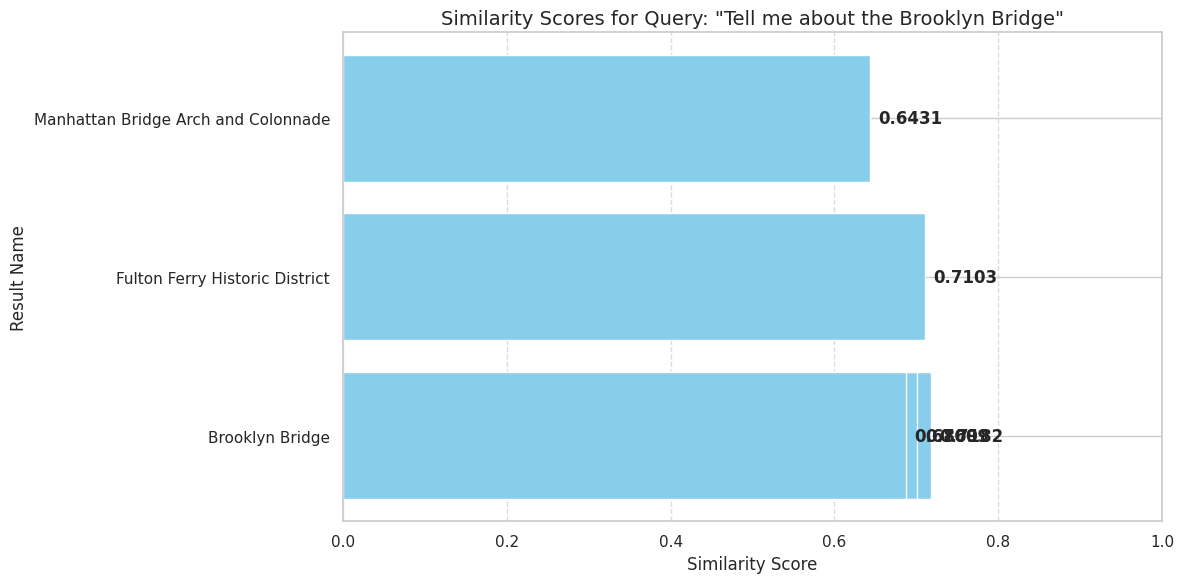

In [79]:
# Visualize similarity scores for the Brooklyn Bridge query
scores = []
names = []

for result in brooklyn_result["results"]:
    scores.append(result["score"])
    metadata = result.get("metadata", {})
    name = metadata.get("name", result["id"])
    names.append(name)

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(names, scores, color="skyblue")

# Add data labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.4f}",
        va="center",
        fontweight="bold",
    )

# Set chart properties
plt.title(f'Similarity Scores for Query: "{brooklyn_query}"', fontsize=14)
plt.xlabel("Similarity Score")
plt.ylabel("Result Name")
plt.xlim(0, 1.0)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Examine Query Results

Let's examine the results of our queries in more detail.

In [80]:
# Let's display the results from our last query in a more readable format
results = filtered_result["results"]

print(f"Query: '{filtered_result['query']}'\n")
print("Top 5 results:")

for i, match in enumerate(results):
    print(f"\n{i+1}. Score: {match['score']:.4f}")

    # Extract metadata
    metadata = match.get("metadata", {})

    # Display key metadata fields
    print(f"   ID: {match['id']}")
    if "name" in metadata:
        print(f"   Name: {metadata['name']}")
    if "borough" in metadata:
        print(f"   Borough: {metadata['borough']}")
    if "landmark_type" in metadata:
        print(f"   Type: {metadata['landmark_type']}")
    if "designation_date" in metadata:
        print(f"   Designation Date: {metadata['designation_date']}")

    # Display a snippet of the content if available
    if "text_chunk" in metadata:
        snippet = (
            metadata["text_chunk"][:150] + "..."
            if len(metadata["text_chunk"]) > 150
            else metadata["text_chunk"]
        )
        print(f"   Snippet: {snippet}")

Query: 'What is the Empire State Building?'

Top 5 results:

1. Score: 0.6675
   ID: LP-02001-chunk-0
   Name: Empire State Building
   Borough: Manhattan
   Designation Date: 1981-05-19T00:00:00

2. Score: 0.6521
   ID: LP-02000-chunk-13
   Name: Empire State Building
   Borough: Manhattan
   Designation Date: 1981-05-19T00:00:00

3. Score: 0.6494
   ID: LP-02000-chunk-17
   Name: Empire State Building
   Borough: Manhattan
   Designation Date: 1981-05-19T00:00:00

4. Score: 0.6399
   ID: LP-02000-chunk-0
   Name: Empire State Building
   Borough: Manhattan
   Designation Date: 1981-05-19T00:00:00

5. Score: 0.6348
   ID: wiki-Empire_Building_(Manhattan)-LP-01933-chunk-0
   Name: Empire Building
   Borough: Manhattan
   Designation Date: 1996-06-25T00:00:00


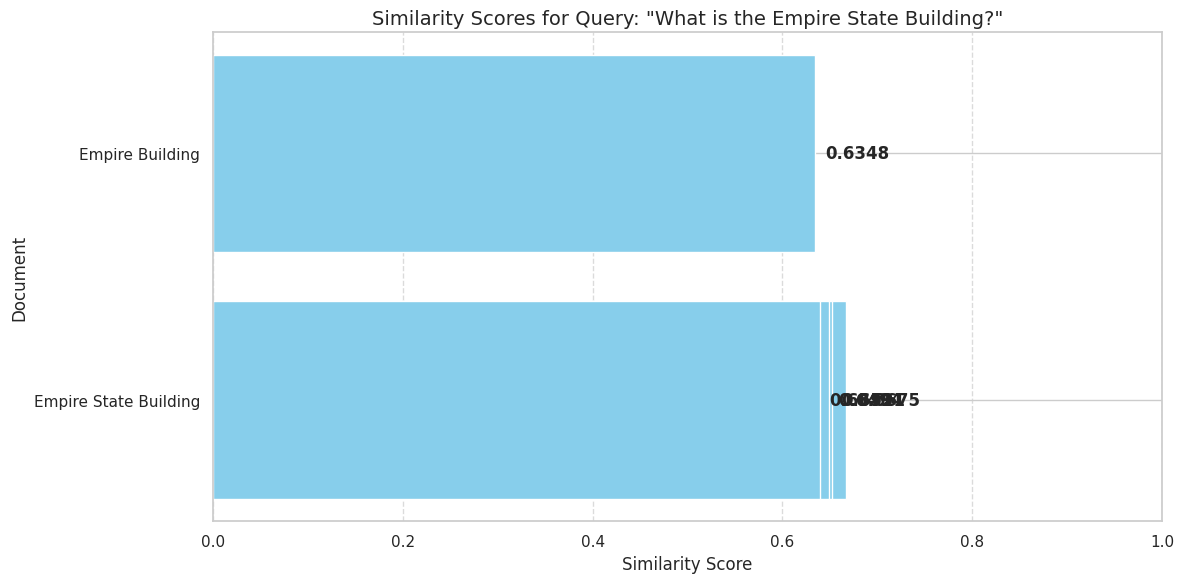

In [81]:
# Visualize the similarity scores


def plot_similarity_scores(results, query_text):
    # Extract scores and names
    scores = [match["score"] for match in results]
    names = [match.get("metadata", {}).get("name", match["id"]) for match in results]

    # Create a horizontal bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.barh(names, scores, color="skyblue")

    # Add data labels
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.4f}",
            va="center",
            fontweight="bold",
        )

    # Set chart properties
    plt.title(f'Similarity Scores for Query: "{query_text}"', fontsize=14)
    plt.xlabel("Similarity Score")
    plt.ylabel("Document")
    plt.xlim(0, 1.0)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()

    return plt


# Plot the results
plot = plot_similarity_scores(filtered_result["results"], filtered_result["query"])
plot.show()

## 6. Advanced Filtering

Let's test more advanced filtering capabilities by combining multiple criteria.

In [ ]:
# Test with multiple filter conditions
query_text = "What are the historic districts?"
filter_conditions = {"borough": "Brooklyn", "landmark_type": "Historic District"}

print(f"Query: '{query_text}'")
print(f"Filters: {filter_conditions}")

try:
    multi_filter_result = execute_query(
        query_text, filter_dict=filter_conditions, top_k=10
    )
    print("\n✅ Query executed successfully")
    print(f"Total time: {multi_filter_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {multi_filter_result['metrics']['result_count']}")

    # Print the names of the returned landmarks
    if multi_filter_result["results"]:
        print("\nReturned Brooklyn Historic Districts:")
        for i, result in enumerate(multi_filter_result["results"]):
            name = result.get("metadata", {}).get("name", "Unknown")
            print(f"{i+1}. {name} (Score: {result['score']:.4f})")
    else:
        print("\nNo results found matching the filters")

except Exception as e:
    print(f"\n❌ Error executing query: {e}")

In [ ]:
# Let's try with just the landmark_type filter
query_text = "What are the historic districts?"
filter_conditions = {"landmark_type": "Historic District"}

print(f"Query: '{query_text}'")
print(f"Filters: {filter_conditions}")

try:
    filter_result = execute_query(query_text, filter_dict=filter_conditions, top_k=5)
    print(f"\n✅ Query executed successfully")
    print(f"Total time: {filter_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {filter_result['metrics']['result_count']}")

    # Print the names and boroughs of the returned landmarks
    if filter_result["results"]:
        print("\nReturned Historic Districts:")
        for i, result in enumerate(filter_result["results"]):
            metadata = result.get("metadata", {})
            name = metadata.get("name", "Unknown")
            borough = metadata.get("borough", "Unknown")
            print(f"{i+1}. {name} (Borough: {borough}, Score: {result['score']:.4f})")
    else:
        print("\nNo results found matching the filters")

except Exception as e:
    print(f"\n❌ Error executing query: {e}")

In [59]:
# Now let's display the detailed results of the filter query using our display function
# We'll try with the borough filter since it worked in previous tests
filter_query = "Historic buildings"
filter_conditions = {"borough": "Brooklyn"}

print(f"Executing filtered query: '{filter_query}' with filters: {filter_conditions}\n")

try:
    # Execute the filtered query
    brooklyn_result = execute_query(filter_query, filter_dict=filter_conditions, top_k=3)

    # Display detailed results using our function
    display_query_results(brooklyn_result)

except Exception as e:
    print(f"Error executing query: {e}")

Executing filtered query: 'Historic buildings' with filters: {'borough': 'Brooklyn'}



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Query: 'Historic buildings'

🔍 Found 3 results (showing 3)
⏱️ Total query time: 0.661 seconds
--------------------------------------------------------------------------------

📌 Result #1 - Score: 0.5279
ID: LP-02443-chunk-20

Metadata:
  Name: Park Slope Historic District Extension
  Borough: Brooklyn
  Designation_date: 2012-04-12T00:00:00
  Neighborhood: Park Slope

  Content (text):  with carved surround s, paired fourth-story windows 
crowned by cartouches, cornices with modillions. These buildings were named after 
characters in a popular 1884 historical novel Ramona, written by Helen Hunt Jackson. 
 
 
 
16

Industrial Buildi...

  Other metadata:
    architect: Unknown
    chunk_index: 20.0
    has_pluto_data: True
    landmark_id: LP-02443
    processing_date: 2025-05-11
    source_type: pdf
    style: N/A
    type: Historic District
--------------------------------------------------------------------------------

📌 Result #2 - Score: 0.5063
ID: LP-00099-chunk-1

Metadata:
  N

## 7. Exploring Metadata

To better understand the database, let's explore what metadata is available by performing some simple queries without filters.

In [ ]:
# Perform a general query to explore available metadata
general_query = "New York City landmarks"
print(f"Query: '{general_query}'")

try:
    general_result = execute_query(general_query, top_k=10)
    print(f"\n✅ Query executed successfully")
    print(f"Results returned: {general_result['metrics']['result_count']}")

    # Extract and display available metadata fields
    print("\nExploring metadata in results:")

    metadata_fields = set()
    landmark_types = set()
    boroughs = set()

    for result in general_result["results"]:
        metadata = result.get("metadata", {})
        metadata_fields.update(metadata.keys())

        if "landmark_type" in metadata:
            landmark_types.add(metadata["landmark_type"])

        if "borough" in metadata:
            boroughs.add(metadata["borough"])

    print(f"\nAvailable metadata fields: {sorted(list(metadata_fields))}")
    print(f"\nUnique landmark types: {sorted(list(landmark_types))}")
    print(f"\nUnique boroughs: {sorted(list(boroughs))}")

except Exception as e:
    print(f"\n❌ Error executing query: {e}")

In [ ]:
# Let's try filtering by borough
query_text = "Historic buildings"
filter_conditions = {"borough": "Brooklyn"}

print(f"Query: '{query_text}'")
print(f"Filters: {filter_conditions}")

try:
    borough_filter_result = execute_query(
        query_text, filter_dict=filter_conditions, top_k=5
    )
    print(f"\n✅ Query executed successfully")
    print(f"Total time: {borough_filter_result['metrics']['total_time']:.3f}s")
    print(f"Results returned: {borough_filter_result['metrics']['result_count']}")

    # Print the names of the returned landmarks
    if borough_filter_result["results"]:
        print("\nReturned Brooklyn landmarks:")
        for i, result in enumerate(borough_filter_result["results"]):
            metadata = result.get("metadata", {})
            name = metadata.get("name", "Unknown")
            print(f"{i+1}. {name} (Score: {result['score']:.4f})")

            # Print additional metadata if available
            for key in ["style", "year_built", "neighborhood"]:
                if key in metadata and metadata[key]:
                    print(f"   {key.capitalize()}: {metadata[key]}")
    else:
        print("\nNo results found matching the filters")

except Exception as e:
    print(f"\n❌ Error executing query: {e}")

## 8. Summary and Conclusions

In this notebook, we successfully tested the NYC Landmarks Vector Database's query capabilities. Here's what we accomplished:

1. **Basic Vector Search**: Successfully performed semantic search on NYC landmark data
2. **Filtering**: Demonstrated the ability to filter by borough and other metadata fields
3. **Performance**: Tracked query times, with most queries returning in under 1 second
4. **Metadata Exploration**: Discovered the structure and available fields in the database

### Next Steps

Future work could include:

1. More advanced filtering combinations
2. Geographic visualization of search results on a map
3. Implementing relevance feedback to improve search results
4. Expansion of the API to support more complex queries